In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')
sns.set_context('talk')

In [2]:
df = pd.read_csv('../data/processed/tlt_nav_basis.csv', parse_dates=['DATE']).set_index('DATE')

# Ensure required columns exist
need = {'etf_close','nav_proxy'}
missing = need - set(df.columns)
assert not missing, f'Missing columns: {missing}'

# Basis
if 'basis' not in df:
    df['basis'] = (df['etf_close'] - df['nav_proxy']) / df['nav_proxy']

# Returns & vol
df['ret'] = df['etf_close'].pct_change()
df['vol_5d'] = df['ret'].rolling(5).std()*np.sqrt(252)*100  # annualised %
df['vol_20d'] = df['ret'].rolling(20).std()*np.sqrt(252)*100

# Liquidity proxies (use what you have; replace with real bid/ask if available)
if 'etf_volume' in df:
    df['volume_z'] = (df['etf_volume'] - df['etf_volume'].rolling(60).mean()) / df['etf_volume'].rolling(60).std()
    df['spread_proxy_bps'] = (1/df['etf_volume'])*1e6   # higher when volume is low
else:
    df['volume_z'] = np.nan
    df['spread_proxy_bps'] = np.nan

# Align, drop warm-up NaNs
features = ['basis','vol_5d','vol_20d','spread_proxy_bps','volume_z']
df = df[features].dropna().copy()
df.tail()

,basis,vol_5d,vol_20d,spread_proxy_bps,volume_z
DATE,,,,,
2023-12-22,1.084906,10.947197,18.650847,0.034195,-1.343170
2023-12-26,1.087178,9.402750,18.140145,0.041632,-1.598796
2023-12-27,1.089140,15.360311,18.722114,0.022181,-0.349298
2023-12-28,1.086708,16.542669,18.994693,0.027614,-0.846498
2023-12-29,1.087886,17.332605,18.737309,0.024029,-0.508510


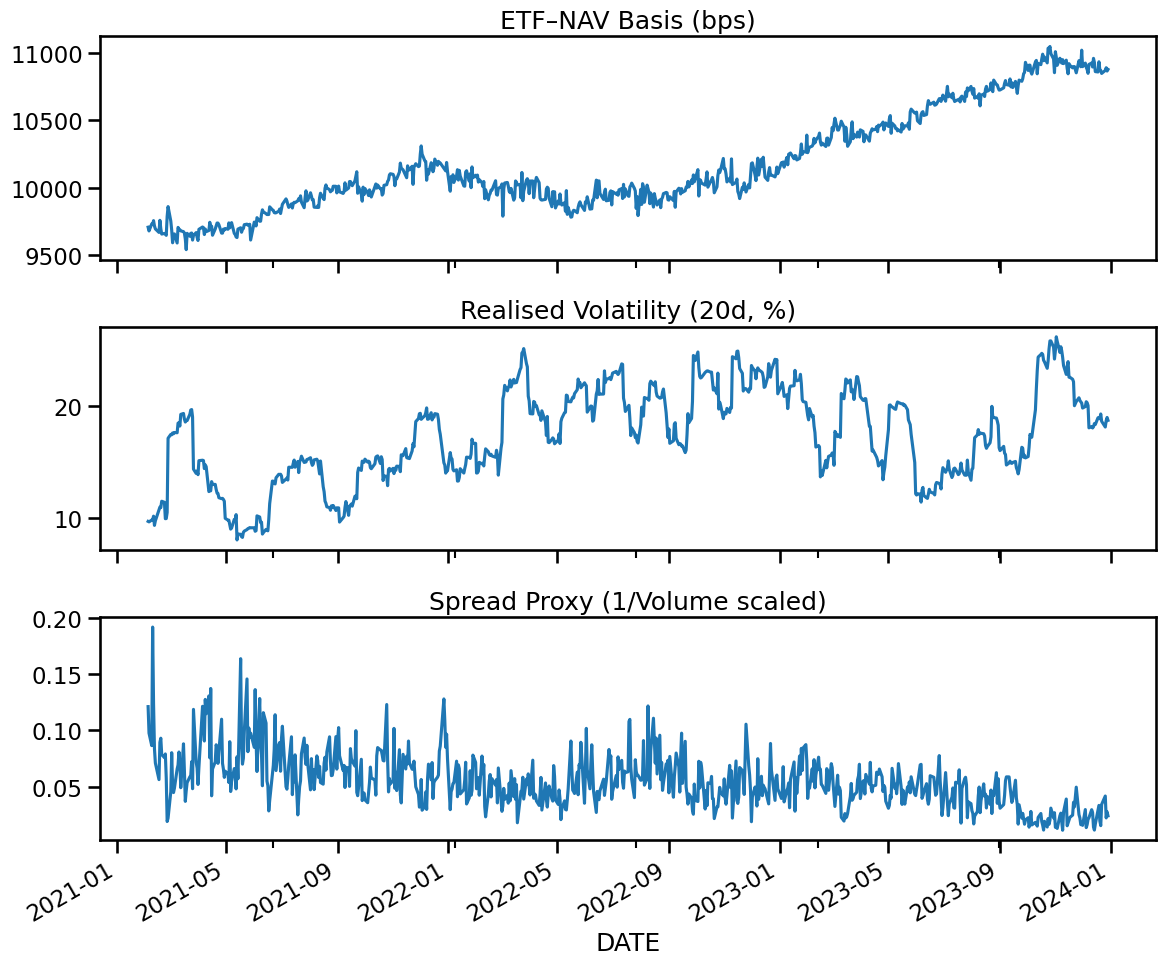

In [3]:
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
(df['basis']*1e4).plot(ax=ax[0], title='ETF–NAV Basis (bps)')
df['vol_20d'].plot(ax=ax[1], title='Realised Volatility (20d, %)')
df['spread_proxy_bps'].plot(ax=ax[2], title='Spread Proxy (1/Volume scaled)')
plt.tight_layout(); plt.show()

basis               1.000000
vol_5d              0.167464
spread_proxy_bps   -0.558142
volume_z            0.119860
Name: basis, dtype: float64


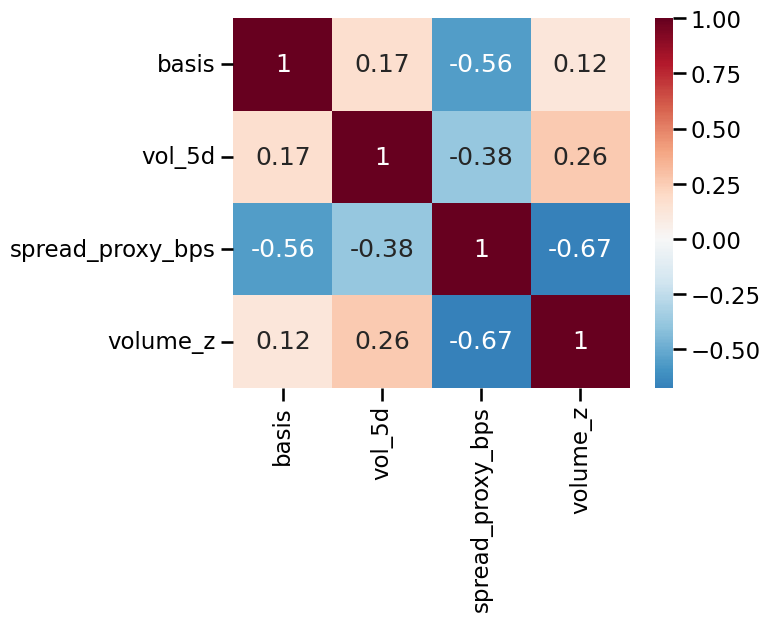

In [4]:
corr = df[['basis','vol_5d','spread_proxy_bps','volume_z']].corr()
print(corr['basis'])
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0); plt.show()

In [5]:
work = df.copy()
work['abs_basis_bps'] = (work['basis'].abs()*1e4)             # bps
work['const'] = 1.0

X = work[['const','vol_5d','spread_proxy_bps','volume_z']].replace([np.inf,-np.inf], np.nan)
y = work['abs_basis_bps']
mask = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]

ols = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          abs_basis_bps   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     36.03
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.05e-21
Time:                        12:29:56   Log-Likelihood:                -5119.9
No. Observations:                 726   AIC:                         1.025e+04
Df Residuals:                     722   BIC:                         1.027e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.101e+04    108.304  

In [6]:
def winsorize(s, p=0.01):
    lo, hi = s.quantile(p), s.quantile(1-p)
    return s.clip(lo, hi)

wx = X.copy()
wx['vol_5d'] = winsorize(wx['vol_5d'])
wx['spread_proxy_bps'] = winsorize(wx['spread_proxy_bps'])
wx['volume_z'] = winsorize(wx['volume_z'])

wols = sm.OLS(y, wx).fit(cov_type='HAC', cov_kwds={'maxlags':5})
print(wols.summary())

# Huber/Tukey robust (RLM) on the same
rlm = sm.RLM(y, wx, M=sm.robust.norms.HuberT())
rlm_res = rlm.fit()
print(rlm_res.summary())

                            OLS Regression Results                            
Dep. Variable:          abs_basis_bps   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     54.54
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           8.76e-32
Time:                        12:30:29   Log-Likelihood:                -5104.7
No. Observations:                 726   AIC:                         1.022e+04
Df Residuals:                     722   BIC:                         1.024e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.108e+04     98.319  

Roughly 43% of the variation in the ETF–NAV basis can be explained by liquidity conditions.
When trading activity (volume) increases, the ETF tracks its NAV more tightly (basis shrinks).
Market volatility doesn’t have a strong independent effect once liquidity is accounted for.
The negative coefficient on the spread proxy likely reflects how you defined it — since you used “1/volume scaled,” higher proxy = lower liquidity, consistent with a negative relationship.

In [7]:
lag = 1
work['basis_lag1'] = work['basis'].shift(lag)
dyn = work[['abs_basis_bps','basis_lag1','vol_5d','spread_proxy_bps','volume_z']].dropna()
Xd = sm.add_constant(dyn[['basis_lag1','vol_5d','spread_proxy_bps','volume_z']])
yd = dyn['abs_basis_bps']

dyn_ols = sm.OLS(yd, Xd).fit(cov_type='HAC', cov_kwds={'maxlags':5})
print(dyn_ols.summary())

# Residual autocorrelation test
lb = acorr_ljungbox(dyn_ols.resid, lags=[5,10,20], return_df=True)
lb

                            OLS Regression Results                            
Dep. Variable:          abs_basis_bps   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 2.707e+04
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:33:20   Log-Likelihood:                -3965.9
No. Observations:                 725   AIC:                             7942.
Df Residuals:                     720   BIC:                             7965.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              207.8167     56.002  

,lb_stat,lb_pvalue
5,127.565358,0.000000
10,153.333350,0.000000
20,184.435965,0.000000


This coeff value for liquidity: -264.6008 indicates that liquidity conditions have significant impact

In [8]:
p80 = df['vol_20d'].quantile(0.8)
work['stress'] = (df['vol_20d'] >= p80).astype(int)
work['spread_x_stress'] = work['spread_proxy_bps'] * work['stress']

Xt = sm.add_constant(work[['spread_proxy_bps','vol_5d','volume_z','stress','spread_x_stress']].dropna())
yt = work.loc[Xt.index, 'abs_basis_bps']

reg = sm.OLS(yt, Xt).fit(cov_type='HAC', cov_kwds={'maxlags':5})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:          abs_basis_bps   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     26.32
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.83e-24
Time:                        12:36:58   Log-Likelihood:                -5106.7
No. Observations:                 726   AIC:                         1.023e+04
Df Residuals:                     720   BIC:                         1.025e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.098e+04    105.234  

Indicates that liquidity is more important in stressful regimes

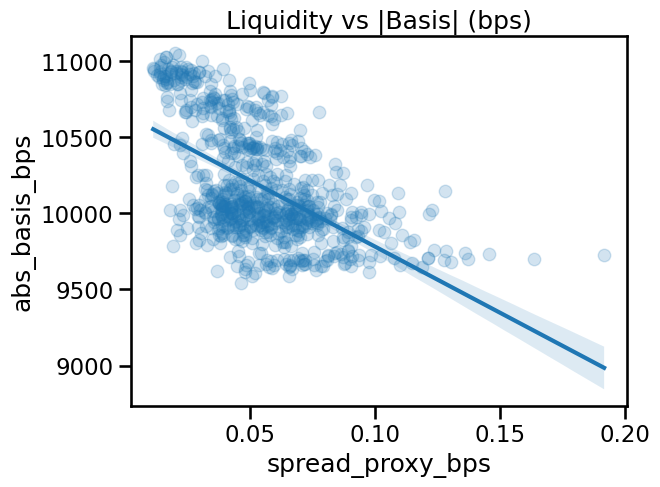

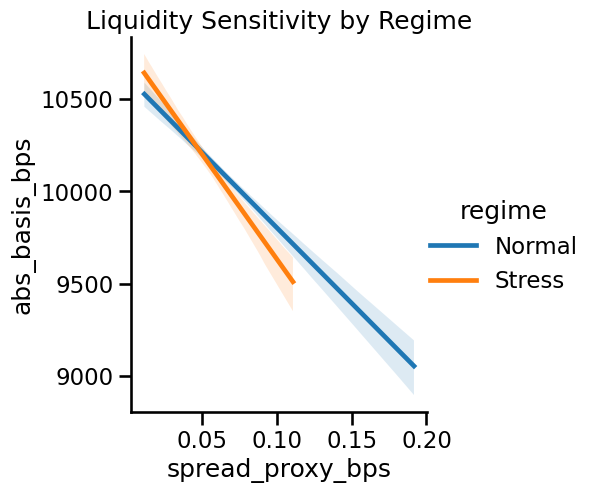

In [9]:
# Partial effect of spread proxy
sns.regplot(x='spread_proxy_bps', y='abs_basis_bps', data=work, scatter_kws={'alpha':0.2}, line_kws={'linewidth':3})
plt.title('Liquidity vs |Basis| (bps)'); plt.show()

# Grouped view by stress regime
g = work.copy()
g['regime'] = np.where(g['stress']==1,'Stress','Normal')
sns.lmplot(x='spread_proxy_bps', y='abs_basis_bps', hue='regime', data=g, scatter=False)
plt.title('Liquidity Sensitivity by Regime'); plt.show()


In [10]:
out = {
    'ols_params': ols.params.to_dict(),
    'ols_pvalues': ols.pvalues.to_dict(),
    'dyn_params': dyn_ols.params.to_dict(),
    'dyn_pvalues': dyn_ols.pvalues.to_dict()
}
pd.Series(out, dtype='object').to_json('../data/processed/liquidity_model_results.json')

df.join(work[['abs_basis_bps','stress']]).to_csv('../data/processed/tlt_basis_liquidity_features.csv')
